In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors
import matplotlib.style as style
from matplotlib.gridspec import GridSpec
import seaborn as sns
%matplotlib inline

from sklearn.mixture import GaussianMixture
#from sklearn.cluster import AffinityPropagation
#from sklearn.cluster import OPTICS, cluster_optics_dbscan
#from sklearn.cluster import DBSCAN
from sklearn.cluster import Birch
from sklearn import metrics

from data_manager import DataManager
import transport_signal_processing as tsp

In [2]:
# parameters
path = "*_K238A_25C_*0mV_ChyS2*"
#'20221114_K238A_25C_80mV_RBDdeltaTRY-4M/CH004_6-0'


#define the cluster cut off
#only clusters that make up a minimum percentage of total events at that voltage are considered for analysis
min_percentage = 10.0
max_stdI = 8

#define cluster numbers:
'''nr_clust = {
    'RBDdeltaCHY-4MKCl': 60,
    'RBDomicronCHY-4MKCl': 90,
    'RBDwtCHY-4MKCl': 50,
    'RBDdeltaTRY-4M': 70,
    'RBDomicronTRY-4M': 70,
    'RBDwtTRY-4M': 70,
}'''

# define cluster numbers: 
nr_clust = {
    '60': 10,
    '80': 10,
    '100': 3,
    '120': 5,
    '140': 5,
    '160': 7,
    '180': 5,
    '200': 10,

}


key_sel = "voltage"
re_sel = ""
level = 1
selected_only = True

# selection of clusters for dwell time plot over voltages
min_dwt = 1.5
max_cur = 15
fsz = 16

In [3]:
# setup database connector
sigman = DataManager('database')

# load segments informations
sinfo_l = sigman.load_info(path, 's*')

# convert info to dataframe
df = pd.DataFrame(sinfo_l)
# keep only key in dataframe and signal info
df = df[df[key_sel].str.match(re_sel) & (df['selected'] > (level-1))]
sinfo_l = [sinfo_l[i] for i in df.index.values]
df = df.reset_index(drop=True)

# set unique instance id
df['iid'] = np.unique(df[key_sel], return_inverse=True)[1]
display(df)

# debug print
key_sels = np.unique(df[key_sel].values)

# load statistics of all events
ids = []
stats = []
for i in range(len(sinfo_l)):
    sinfo = sinfo_l[i]
    curr_path = sigman.define_db_path(sinfo)
    
    s_l = sigman.load_data(curr_path, 's{}-stats'.format(sinfo['sid']))
    if len(s_l) > 0:
        s = s_l[0]
        m = sigman.load_data(curr_path, 's{}-selected'.format(sinfo['sid']))[0].astype(bool)
        if selected_only:
            s = s[m]

        ids.append(df['iid'].values[i] * np.ones(s.shape[0], dtype=int))
        # rescale mean and standard deviation based on open pore stats
        s[:,1] = 100.0 * s[:,1] / sinfo['mI_open']
        s[:,2] = s[:,2] / sinfo['sI_open']
        #s[:,2] = 100.0 * s[:,2] / sinfo['mI_open']
        stats.append(s)
        
ids_stats = np.concatenate(ids)
stats = np.concatenate(stats)

# rescale dwell time s -> ms
stats[:,0] = np.log10(stats[:,0] * 1e3)

# load find reduced stats for each selected cases
stats_dict = {}
for pn in key_sels:
    df_pn = df[df[key_sel] == pn]
    
    m = np.zeros(ids_stats.shape, dtype=bool)
    for i in np.unique(df_pn['iid']):
        if i in ids_stats:
            m = (m | (ids_stats == i))
    
    stats_dict[pn] = stats[m]
    

# debug print
print(ids_stats.shape)
print(stats.shape)

,date,pore,temperature,voltage,polymer_name,channel,id,sid,segment_range,segment_duration,MODIFIED,mI_open,sI_open,N_events,N_cores,N_reduced,selected,ratio_sel,iid
0,20230713,K238A,25,140,ChyS2-4MKCl,001,4,0,"[0, 1203975]",12.03975,2023-08-14_10:41:23,383.957982,4.971881,218,142.0,142.0,1.0,0.274648,2
1,20230713,K238A,25,140,ChyS2-4MKCl,001,4,1,"[1344925, 2198835]",8.53910,2023-08-14_10:41:23,384.267402,4.996106,89,57.0,57.0,1.0,0.263158,2
2,20230713,K238A,25,140,ChyS2-4MKCl,001,4,2,"[2254823, 2666829]",4.12006,2023-08-14_10:41:23,384.501646,5.021821,32,23.0,23.0,1.0,0.304348,2
3,20230713,K238A,25,140,ChyS2-4MKCl,001,4,3,"[2717766, 4984514]",22.66748,2023-08-14_10:41:23,383.956456,4.986622,413,281.0,281.0,1.0,0.274021,2
4,20230713,K238A,25,140,ChyS2-4MKCl,001,4,4,"[5061507, 5408474]",3.46967,2023-08-14_10:41:23,384.686661,5.047306,17,15.0,15.0,1.0,0.400000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1905,20230707,K238A,25,180,ChyS2-4MKCl,004,9,39,"[36519766, 37379670]",8.59904,2023-08-14_10:41:25,457.426116,7.072131,129,89.0,89.0,1.0,0.303371,4
1906,20230707,K238A,25,180,ChyS2-4MKCl,004,9,40,"[37467659, 37696661]",2.29002,2023-08-14_10:41:25,463.181177,8.996010,2,2.0,2.0,1.0,0.000000,4
1907,20230707,K238A,25,180,ChyS2-4MKCl,004,9,41,"[37756621, 38122574]",3.65953,2023-08-14_10:41:25,456.885616,8.960637,12,6.0,6.0,1.0,0.500000,4
1908,20230707,K238A,25,180,ChyS2-4MKCl,004,9,43,"[38569505, 38828474]",2.58969,2023-08-14_10:41:25,453.224936,6.982376,32,27.0,27.0,1.0,0.481481,4


(211551,)
(211551, 5)


In [4]:
#note: agglomerative clustering does not work on the data
#0 = dwell time of event #1 mean residual current #2 skewness #3 kurtosis  #4 standard deviation 

3 clusters without noise


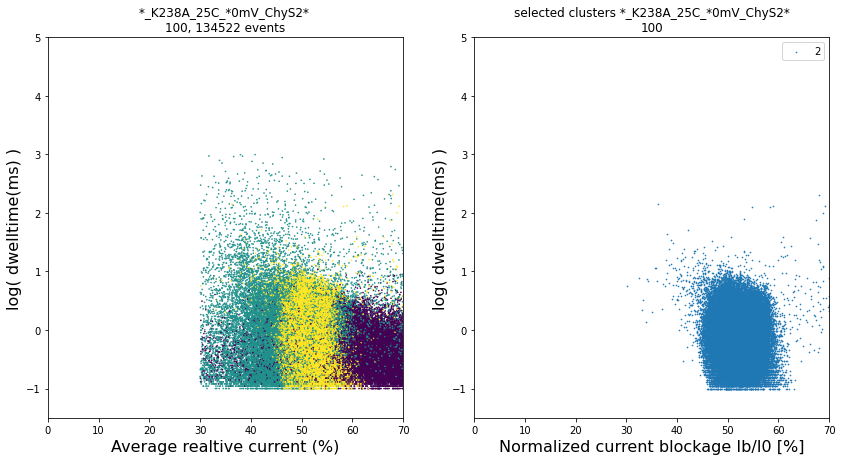

5 clusters without noise


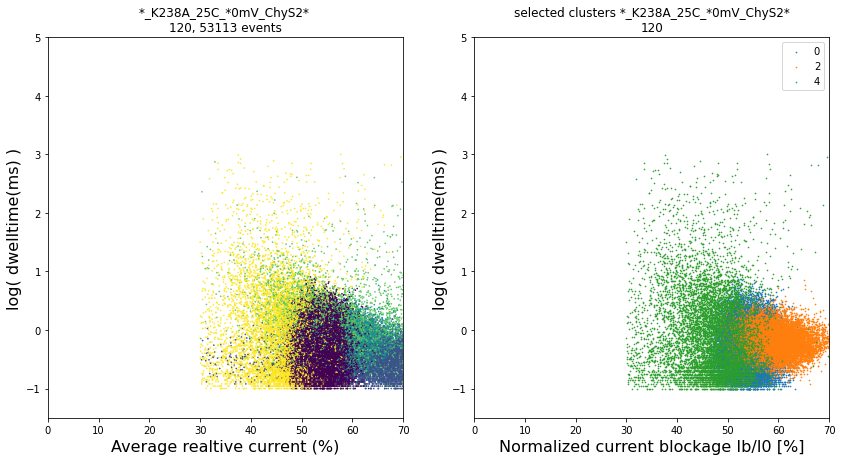

5 clusters without noise


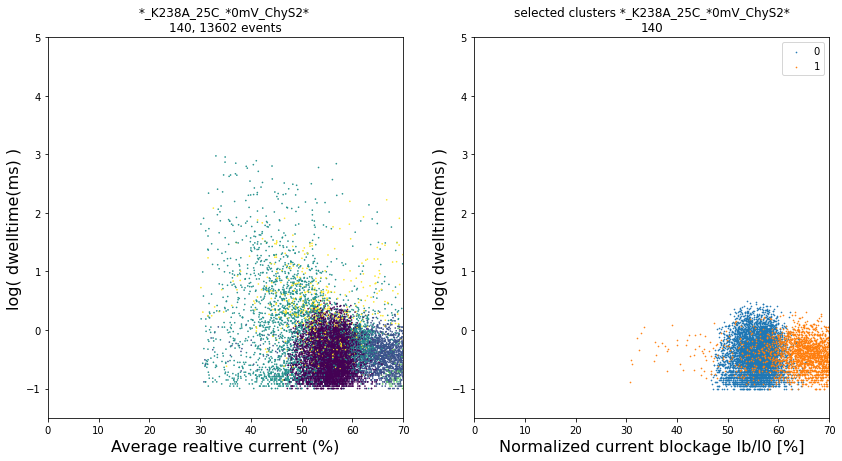

7 clusters without noise


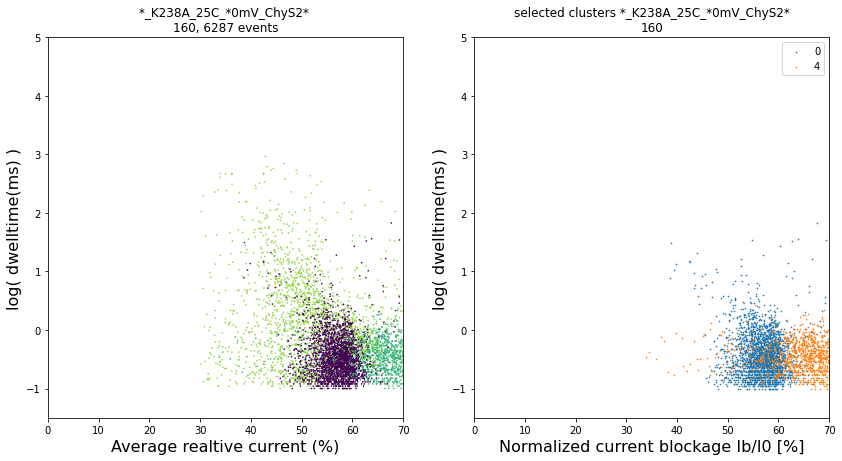

5 clusters without noise


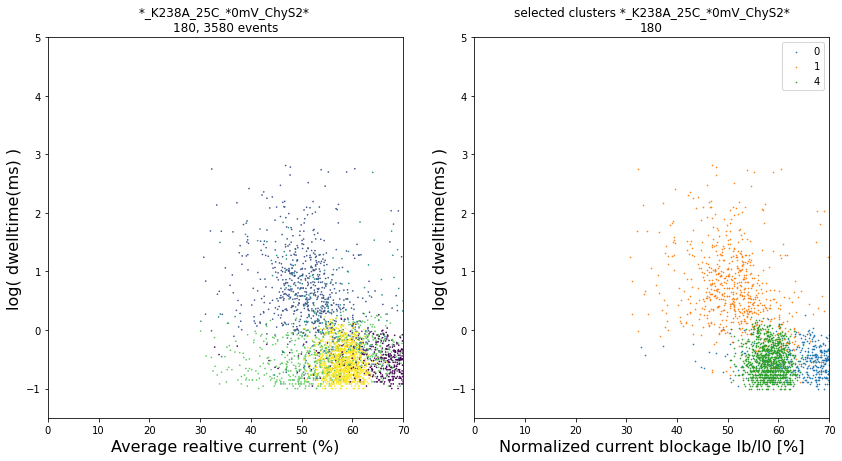

10 clusters without noise


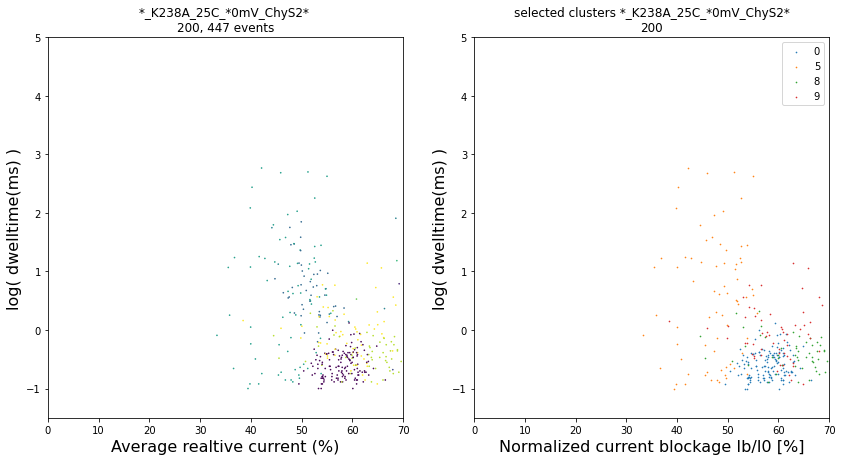

In [5]:
values =[]

for pn in key_sels:
    # extract stats
    data = stats_dict[pn][:,0:5].copy() 
    x = data
    X = x[:, [0,1,2,4]]
    damping = 0.9
    clst = GaussianMixture(nr_clust[pn], covariance_type='full')
    # get labels
    y = clst.fit_predict(X)
 
    ###clst = Birch(n_clusters = DBSCAN(eps=0.34, min_samples=10), threshold = 0.1, branching_factor = 200)
    #clst = Birch(n_clusters = GaussianMixture(nr_clust[pn],covariance_type='full'), threshold = 0.1, branching_factor = 200)
    #y = clst.fit_predict(X)
    
    #af = AffinityPropagation(damping=damping, random_state = 13).fit(X)
    #y = af.labels_
    
   # db = DBSCAN(eps=1.3, min_samples=1000).fit(X)
   # y = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(y)) - (1 if -1 in y else 0)
    n_noise_ = list(y).count(-1)
    print('{} clusters without noise'.format(n_clusters_))
    
    #extract mean values for all dimensions of selected clusters: 
    for i in range(0,len(np.unique(y)),1):
            cluster_ID =  np.mean(x[np.where(y==i), 0][0])+np.mean(x[np.where(y==i), 1][0])+np.mean(x[np.where(y==i), 2][0])+np.mean(x[np.where(y==i), 3][0])+np.mean(x[np.where(y==i), 4][0])
            values.append({
                            'voltage [mV]': pn,
                            'cluster_nr': i,
                            'cluster_ID': cluster_ID,
                            'nr_events': len(x[np.where(y==i), 1][0]),
                            'mean_current[pA]': np.mean(x[np.where(y==i), 1][0]), 
                            'mean_log_dwt': np.mean(x[np.where(y==i), 0][0]),
                            'mean_skewness': np.mean(x[np.where(y==i), 2][0]),
                            'mean_kurtosis':np.mean(x[np.where(y==i), 3][0]),
                            'mean_rel_std[pA]':np.mean(x[np.where(y==i), 4][0]),
                            'std_current[pA]': np.std(x[np.where(y==i), 1][0]), 
                            'std_log_dwt': np.std(x[np.where(y==i), 0][0]),
                            'std_skewness': np.std(x[np.where(y==i), 2][0]),
                            'std_kurtosis':np.std(x[np.where(y==i), 3][0]),
                            'std_rel_std[pA]':np.std(x[np.where(y==i), 4][0]),
                        })

    
    plt.figure(figsize = (14,7))
    gs = GridSpec(nrows=1, ncols=2)
    #plot of all clusters
    plt.subplot(gs[0,0])
    plt.scatter(x[:, 1], x[:, 0], c=y, s=0.4, cmap='viridis', label = y)
    #plt.plot([max_cur]*2,[-0.5,5] , '--', color = 'grey')
    #plt.plot([-5,80], [min_dwt]*2 , '--', color = 'grey')
    plt.xlabel('Average realtive current (%)', fontsize = fsz)
    plt.ylabel('log( dwelltime(ms) )', fontsize = fsz)
    plt.title('''{} 
{}, {} events'''.format(path, pn, len(x[:,1])))
    plt.xlim(0,70)
    plt.ylim(-1.5,5)
   
    #plot of selected clusters
    plt.subplot(gs[0,1])
    for n, i in enumerate(np.unique(y)):
        if len(x[np.where(y==i), 1][0]) > (min_percentage * len(y)/ 100): 
            if np.std(x[np.where(y==i), 1][0]) < max_stdI:
                if i >= 0:
                    plt.scatter(x[np.where(y==i), 1], x[np.where(y==i), 0], s=0.4, label=i) 
    plt.legend(loc = 'best')
    plt.xlabel('Normalized current blockage Ib/I0 [%]', fontsize = fsz)
    plt.ylabel('log( dwelltime(ms) )', fontsize = fsz)
    plt.title('''selected clusters {}
{}'''.format(path, pn))
    plt.xlim(0,70)
    plt.ylim(-1.5,5)
    plt.savefig('graphs/{}_{}mV_Clustering.png'.format(path,pn), dpi=300)
    plt.show() 
    
df_values = pd.DataFrame(values)
    

In [6]:
### df_values = df_values.sort_values('voltage [mV]')
df_values['Sel_min_percentage[%]'] = min_percentage
df_values['Sel_max_stdI[pA]'] = max_stdI
#df_values.to_csv("csv_files/{}_MeanClusterValues_filtered.csv".format(path), index = False)
df_values

,voltage [mV],cluster_nr,cluster_ID,nr_events,mean_current[pA],mean_log_dwt,mean_skewness,mean_kurtosis,mean_rel_std[pA],std_current[pA],std_log_dwt,std_skewness,std_kurtosis,std_rel_std[pA],Sel_min_percentage[%],Sel_max_stdI[pA]
0,100,0,76.342320,32890,65.218624,-0.371737,11.313700,0.402017,-0.220283,8.397474,0.324637,4.741732,0.809651,1.219945,10.0,8
1,100,1,61.032098,33383,50.975123,-0.074010,7.119504,-0.029556,3.041037,9.115209,0.549064,2.028550,1.571370,3.064066,10.0,8
2,100,2,59.958632,68249,52.721652,-0.110329,3.971076,-0.980554,4.356787,3.067660,0.389972,1.067937,1.286987,4.364896,10.0,8
3,120,0,59.589095,21828,54.581405,-0.304512,3.873679,-1.099219,2.537742,2.836790,0.342813,1.115573,0.807901,2.372163,10.0,8
4,120,1,80.503888,8247,68.836084,-0.554790,13.069374,0.143543,-0.990322,8.220615,0.241166,6.145472,0.579816,0.660253,10.0,8
5,120,2,73.987142,7468,60.399235,-0.179285,10.559712,1.200023,2.007456,4.219724,0.237168,1.939335,0.871254,1.984509,10.0,8
6,120,3,72.980145,8055,59.214672,0.024372,5.512933,-0.550770,8.778938,9.540768,0.476116,1.947182,2.270371,5.629167,10.0,8
7,120,4,53.910856,7515,46.210734,-0.041510,7.673979,-0.722972,0.790624,5.784508,0.732841,2.682174,0.778247,1.572367,10.0,8
8,140,0,61.167043,5862,55.829611,-0.435201,4.318257,-0.989744,2.444120,2.945525,0.306222,1.565502,1.051568,2.593732,10.0,8
9,140,1,81.658938,3108,67.847220,-0.462972,14.526039,0.462596,-0.713945,7.155772,0.247938,4.472476,0.621342,0.905099,10.0,8
